In [1]:
!pip install doubleml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.8/471.8 kB 11.1 MB/s eta 0:00:00


In [2]:
import sys
import doubleml

print(f"Python version: {sys.version}")
print(f"DoubleML version: {doubleml.__version__}")

Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
DoubleML version: 0.10.1


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from doubleml import DoubleMLData, DoubleMLPLR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
import warnings
from typing import List, Dict

warnings.filterwarnings('ignore')

**Data preparation**

In [72]:
data = pd.read_csv("global_combined_HDD.csv")

# 处理wealth列
data['wealth'] = np.where((data['wealth'] == -1) & (data['income'] != -1),
                         data['income'], data['wealth'])
data = data[data['wealth'] != -1]
data = data.drop(columns=["income", "total_HDD", "mean_temp", "threshold"])

# 计算滞后碳排放量
data = data.sort_values(by=['GDLcode', 'time'])
data['carbon_emission_lag1'] = data.groupby('GDLcode')['carbon emission'].shift(1)

data = data.dropna()
data = data[data['HDD_days'] != 0]

countries = ["AUT", "BEL", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN", "FRA", "DEU", "GRC", "HUN", "IRL", "ITA", "LVA", "LTU", "LUX", "MLT", "NLD", "POL", "PRT", "ROU", "SVK", "SVN", "ESP", "SWE"]
#countries = ["GBR"]
#countries = ["CAN"]
#countries = ["USA"]
#countries = ["CHN"]
#countries = ["RUS"]

data = data[data['GDLcode'].str.contains('|'.join(countries), na=False)]

**Data cleansing**

In [73]:
df = data.copy()

# 计算 IQR
Q1 = df['carbon emission'].quantile(0.25)
Q3 = df['carbon emission'].quantile(0.75)
IQR = Q3 - Q1

# 设置上下界
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# 标记异常值
df['outlier'] = (df['carbon emission'] < lower_bound) | (df['carbon emission'] > upper_bound)

# 打印异常值数量
print(f"检测到 {df['outlier'].sum()} 条 carbon emission 异常值，共 {len(df)} 条记录")

# 删除异常值
data = df[~df['outlier']].drop(columns='outlier')

检测到 1351 条 carbon emission 异常值，共 14012 条记录


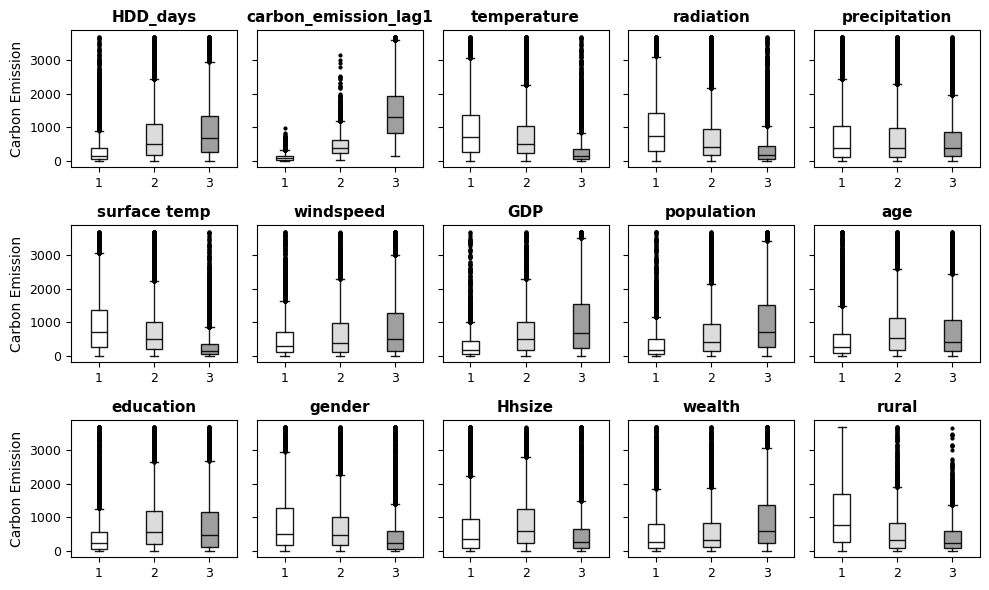

In [74]:
variables = ["HDD_days", "carbon_emission_lag1", "temperature", "radiation", "precipitation","surface temp", "windspeed",
             "GDP", "population", "age","education", "gender", "Hhsize", "wealth", "rural"]

df = data[variables + ['carbon emission']].copy()

df_long = pd.melt(df, id_vars='carbon emission', value_vars=variables,
                  var_name='Variable', value_name='Value')

df_long['VarGroup'] = df_long.groupby('Variable')['Value'] \
                             .transform(lambda x: pd.qcut(x, 3, labels=False, duplicates='drop') + 1)

ncol = 5
nrow = int(np.ceil(len(variables) / ncol))
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 2, nrow * 2), sharey=True)
axes = axes.flatten()

# 灰度配色
gray_colors = plt.cm.Greys(np.linspace(0, 0.5, 3))

# 绘图
for i, var in enumerate(variables):
    ax = axes[i]
    subset = df_long[df_long['Variable'] == var]
    groups = [group["carbon emission"].values for name, group in subset.groupby('VarGroup')]

    box = ax.boxplot(groups, patch_artist=True, showfliers=True,
                     flierprops=dict(marker='o', markerfacecolor='black', markersize=2, linestyle='none'))

    # 设置箱体颜色
    for patch, color in zip(box['boxes'], gray_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_alpha(0.9)

    # 设置须、帽、中位线颜色
    for element in ['whiskers', 'caps', 'medians']:
        for line in box[element]:
            line.set_color('black')
            line.set_alpha(0.9)

    ax.set_title(var, fontweight='bold', fontsize=11)
    ax.set_xticklabels([str(i) for i in range(1, len(groups)+1)], fontsize=9)
    ax.tick_params(axis='y', labelsize=9)
    if i % ncol == 0:
        ax.set_ylabel('Carbon Emission', fontsize=10)

# 删除多余子图
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

**DML model**

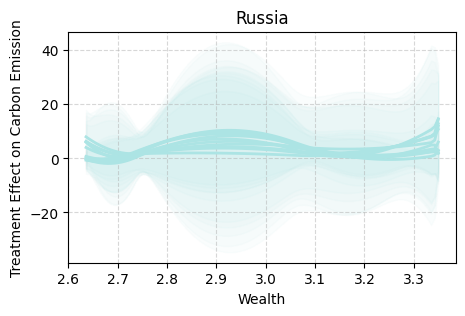


=== Main Analysis Summary (LASSO + RF) ===
                     coef_mean  coef_std  std_err_mean  t_mean  p_value_mean
model_type term                                                             
Main       HDD_days     1.4954    0.5987        0.9736  1.5171        0.1636

=== Robustness Check Summary (XGBoost + RF) ===
                     coef_mean  coef_std  std_err_mean  t_mean  p_value_mean
model_type term                                                             
Robust     HDD_days     4.0569    0.4054        1.6974  2.3928        0.0191

Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [ ]:
# 定义参数网格
def get_param_grids():
    lasso_params = {
        'alphas': [np.logspace(-5, 0, 5, 10)],
        'max_iter': [100, 500, 800, 1000],
        'cv': [5]
    }

    rf_params = {
        'n_estimators': [100, 250, 500],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 6, 10]
    }

    xgb_params = {
        'n_estimators': [100, 250, 500],
        'max_depth': [3, 5, 10],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.3, 0.5, 1.0]
    }

    return {'ml_l': xgb_params, 'ml_m': rf_params}, {'ml_l': lasso_params, 'ml_m': rf_params}

# 主分析类
class DoubleMLAnalysis:
    def __init__(self, data: pd.DataFrame, X_cols: List[str], y_col: str, d_cols: str):
        self.data = data
        self.X_cols = X_cols
        self.y_col = y_col
        self.d_cols = d_cols
        self.results_main = pd.DataFrame()
        self.results_robust = pd.DataFrame()
        self.cate_results = []

    def _prepare_spline_basis(self, var_name="wealth", df=5, degree=2):
        """准备样条基函数"""
        formula = f"bs({var_name}, df={df}, degree={degree})"
        design_matrix = patsy.dmatrix(formula, {var_name: self.data[var_name]})
        return pd.DataFrame(design_matrix)

    def _prepare_spline_grid(self, var_name="wealth", n_points=100, design_info=None):
        """生成预测网格"""
        new_data = {var_name: np.linspace(self.data[var_name].min(),
                    self.data[var_name].max(), n_points)}
        return pd.DataFrame(patsy.build_design_matrices([design_info], new_data)[0])

    def _process_cate(self, cate, design_info, var_name="wealth"):
        """处理CATE结果"""
        spline_grid = self._prepare_spline_grid(var_name=var_name, design_info=design_info)
        df_cate = cate.confint(spline_grid, level=0.95, joint=True, n_rep_boot=2000)
        df_cate[var_name] = np.linspace(self.data[var_name].min(),
                                       self.data[var_name].max(),
                                       len(df_cate))
        return df_cate

    def _plot_cates(self, cate_results: List[Dict], var_name="wealth"):
        """绘制CATE曲线（跳过Treatment Effect=0的点）"""
        plt.figure(figsize=(5, 3))
        base_color = "#ace4e4" #colors = {'EU': '#e8e8e8','UK': '#5ac8c8','Canada': '#a5add3','US': '#be64ac','China': '#3b4994','Russia': '#ace4e4'}

        for i, res in enumerate(cate_results):
          df = res['cate_df']
          label = f"{res['model_type']} (Run {res['run']})"

          # 绘制曲线和置信区间
          line = plt.plot(df[var_name], df['effect'],
                        color=base_color,
                        alpha=1,
                        linewidth=2,
                        label=label)

          # 使用相同颜色但更浅的置信区间
          plt.fill_between(df[var_name],
                          df['2.5 %'],
                          df['97.5 %'],
                          color=base_color,
                          alpha=0.05)

        # 设置图例和标题
        #plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left',frameon=False)
        #plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.title("Russia")
        plt.xlabel(var_name.capitalize())
        plt.ylabel('Treatment Effect on Carbon Emission')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    def run_analysis(self, num_runs):
        main_param_grids, robust_param_grids = get_param_grids()

        for i in range(1, num_runs + 1):
            np.random.seed(i)
            dml_data = DoubleMLData(self.data, self.y_col, self.d_cols, self.X_cols)

            # 主分析 (XGBoost + RF)
            try:
                model_main = DoubleMLPLR(dml_data, XGBRegressor(), RandomForestRegressor())
                model_main.tune(main_param_grids, tune_on_folds=False, n_folds_tune=5)
                model_main.fit(n_jobs_cv=8)

                # 存储结果
                s = model_main.summary
                if not s.empty:
                    self.results_main = pd.concat([
                        self.results_main,
                        self._process_results(s, i, "Main")
                    ], ignore_index=True)

                # 计算并存储CATE
                design_matrix = patsy.dmatrix("bs(wealth, df=5, degree=2)",
                                             {"wealth": self.data["wealth"]})
                cate = model_main.cate(pd.DataFrame(design_matrix))
                df_cate = self._process_cate(cate, design_matrix.design_info)
                self.cate_results.append({
                    'run': i,
                    'model_type': 'XGBoost+RF',
                    'cate_df': df_cate,
                    'model': model_main
                })

            except Exception as e:
                print(f"Main Run {i} failed: {str(e)}")

            # 鲁棒性检验 (LASSO + RF)
            try:
                model_robust = DoubleMLPLR(dml_data, LassoCV(), RandomForestRegressor())
                model_robust.tune(robust_param_grids, tune_on_folds=False, n_folds_tune=5)
                model_robust.fit(n_jobs_cv=8)

                s = model_robust.summary
                if not s.empty:
                    self.results_robust = pd.concat([
                        self.results_robust,
                        self._process_results(s, i, "Robust")
                    ], ignore_index=True)

                # 计算并存储CATE
                cate = model_robust.cate(pd.DataFrame(design_matrix))  # 使用相同的design_matrix
                df_cate = self._process_cate(cate, design_matrix.design_info)
                self.cate_results.append({
                    'run': i,
                    'model_type': 'LASSO+RF',
                    'cate_df': df_cate,
                    'model': model_robust
                })

            except Exception as e:
                print(f"Robustness Run {i} failed: {str(e)}")

        # 可视化所有CATE结果
        self._plot_cates(self.cate_results)

        return self

    def _process_results(self, summary_df, run_id, model_type):
        """处理结果数据框"""
        df = summary_df.reset_index().rename(
            columns={'index': 'term', 'std err': 'std_err', 'P>|t|': 'p_value'})
        df['run'] = run_id
        df['model_type'] = model_type
        return df

    def get_summary_stats(self):
        """生成汇总统计"""
        def _create_summary(df):
            if not df.empty:
                summary = df.groupby(['model_type', 'term']).agg({
                    'coef': ['mean', 'std'],
                    'std_err': 'mean',
                    't': 'mean',
                    'p_value': 'mean'
                })
                summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
                return summary
            return pd.DataFrame()

        return {
            'main': _create_summary(self.results_main),
            'robust': _create_summary(self.results_robust)
        }

if __name__ == "__main__":
    analysis = DoubleMLAnalysis(
        data=data,
        X_cols=["carbon_emission_lag1", "temperature", "radiation", "precipitation",
                "surface temp", "windspeed", "GDP", "population", "age",
                "education", "gender", "Hhsize", "wealth", "rural"],
        y_col="carbon emission",
        d_cols="HDD_days"
    )

    # 运行分析次数
    analysis.run_analysis(num_runs=5)

    # 获取汇总统计
    summaries = analysis.get_summary_stats()

    print("\n=== Main Analysis Summary (XGBoost + RF) ===")
    print(summaries['main'].round(4))

    print("\n=== Robustness Check Summary (LASSO + RF)  ===")
    print(summaries['robust'].round(4))

    print("\nSignif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")

**Robustness check**

In [4]:
!pip install econml lightgbm catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, ElasticNetCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from econml.dml import LinearDML, CausalForestDML
from econml.dr import DRLearner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 17.2 MB/s eta 0:00:00


In [54]:
class DoubleMLAnalysis:
    def __init__(self, data, X_cols, y_col, d_cols):
        """
        初始化分析类
        :param data: pandas DataFrame
        :param X_cols: list, 特征变量列
        :param y_col: str, 因变量列
        :param d_cols: str 或 list, 处理变量列
        """
        self.data = data
        self.X_cols = X_cols
        self.y_col = y_col
        self.d_cols = d_cols
        self.results_df = None

    # 1 & 2: nuanced function estimation + orthogonalization & CV
    def run_analysis(self, n_splits=5):
        """运行多 learner 组合，比较 cross-fitting vs no cross-fitting，并输出 orthogonal score diagnostic"""

        learners = [
            ('xgb_rf', (XGBRegressor(n_estimators=250, max_depth=5), RandomForestRegressor(n_estimators=250))),
            ('lasso_rf', (LassoCV(cv=5), RandomForestRegressor(n_estimators=250))),
            ('lgbm_rf', (LGBMRegressor(n_estimators=250), RandomForestRegressor(n_estimators=250))),
            ('elasticnet_lgbm', (ElasticNetCV(cv=5), LGBMRegressor(n_estimators=250))),
            ('catboost_rf', (CatBoostRegressor(verbose=0, iterations=250), RandomForestRegressor(n_estimators=250)))
        ]

        results = []
        X = self.data[self.X_cols]
        Y = self.data[self.y_col]
        D = self.data[self.d_cols]

        cv = KFold(n_splits=n_splits, shuffle=True, random_state=123)

        for name, (ml_y, ml_t) in learners:
            print(f'Running learner combination: {name}')

            # 1) Cross-fitting
            dml_cf = LinearDML(model_y=ml_y, model_t=ml_t, cv=cv, random_state=123)
            dml_cf.fit(Y, D, X=X)
            ate_cf = dml_cf.ate(X=X)
            ate_ci_cf = dml_cf.ate_interval(X=X, alpha=0.05)

            # Orthogonal score diagnostic
            m_hat_list = [model.predict(X) for model in dml_cf.models_y[0]]
            g_hat_list = [model.predict(X) for model in dml_cf.models_t[0]]

            m_hat = np.mean(m_hat_list, axis=0)
            g_hat = np.mean(g_hat_list, axis=0)

            resid_y = Y - m_hat
            resid_d = D - g_hat

            ortho_mean = np.mean(resid_y * resid_d)
            ortho_std = np.std(resid_y * resid_d)

            # 2) No cross-fitting
            dml_nocf = LinearDML(model_y=ml_y, model_t=ml_t, cv=1, random_state=123)
            dml_nocf.fit(Y, D, X=X)
            ate_nocf = dml_nocf.ate(X=X)
            ate_ci_nocf = dml_nocf.ate_interval(X=X, alpha=0.05)

            results.append({
                'learner': name,
                'ate_cf': ate_cf,
                'ci_cf_lower': ate_ci_cf[0],
                'ci_cf_upper': ate_ci_cf[1],
                'ate_nocf': ate_nocf,
                'ci_nocf_lower': ate_ci_nocf[0],
                'ci_nocf_upper': ate_ci_nocf[1],
                'ortho_mean': ortho_mean,
                'ortho_std': ortho_std
            })

        self.results_df = pd.DataFrame(results)
        return self.results_df

    def plot_forest(self):
        """绘制森林图 (Cross vs No Cross) + Orthogonal score 子图"""
        if self.results_df is None:
            raise ValueError("请先运行 run_analysis() 生成结果")

        df = self.results_df.copy()
        y_pos = np.arange(len(df))

        fig, axes = plt.subplots(1, 2, figsize=(8, len(df) * 0.8), gridspec_kw={'width_ratios': [1.8, 1]})

        # --- 子图1: ATE 森林图 ---
        ax1 = axes[0]
        # Cross-fitting
        ax1.errorbar(df['ate_cf'], y_pos + 0.15,
                    xerr=[df['ate_cf'] - df['ci_cf_lower'], df['ci_cf_upper'] - df['ate_cf']],
                    fmt='o', color='blue', label='Cross-fitting')
        # No cross-fitting
        ax1.errorbar(df['ate_nocf'], y_pos - 0.15,
                    xerr=[df['ate_nocf'] - df['ci_nocf_lower'], df['ci_nocf_upper'] - df['ate_nocf']],
                    fmt='o', color='red', label='No cross-fitting')

        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(df['learner'])
        ax1.axvline(0, color='black', linestyle='--')
        ax1.set_xlabel("ATE Estimate")
        ax1.set_title("ATE estimates with 95% CI")
        ax1.legend()

        # --- 子图2: Orthogonal score ---
        ax2 = axes[1]
        ax2.errorbar(df['ortho_mean'], y_pos,
                    xerr=df['ortho_std'],
                    fmt='o', color='green')
        ax2.axvline(0, color='black', linestyle='--')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels([])  # Y 轴标签由左侧共享
        ax2.set_xlabel("Orthogonal Score (mean ± std)")
        ax2.set_title("Orthogonalization diagnostic")

        plt.tight_layout()
        plt.show()

    # 3: other estimation approaches
    def compare_estimators(self):
        """比较 LinearDML, CausalForestDML, DRLearner 等不同估计方法"""
        X = self.data[self.X_cols]
        Y = self.data[self.y_col]
        D = self.data[self.d_cols]

        results = {}

        # Linear DML
        lin = LinearDML(model_y=RandomForestRegressor(200),
                        model_t=RandomForestRegressor(200), cv=5)
        lin.fit(Y, D, X=X)
        results['LinearDML_ATE'] = lin.ate(X=X)

        # Causal Forest DML
        cf = CausalForestDML(model_t=RandomForestRegressor(200),
                             model_y=RandomForestRegressor(200),
                             n_estimators=200, cv=5)
        cf.fit(Y, D, X=X)
        results['CausalForest_mean'] = cf.effect(X).mean()

        return results

    # 4: model assumption check
    def check_common_support(self, lower=0.05, upper=0.95, do_trim=True, plot=True):
        """
        检查处理组/对照组的 propensity score overlap，并可选执行 trimming
        :param lower: float, trimming 下限 (默认 0.05)
        :param upper: float, trimming 上限 (默认 0.95)
        :param do_trim: bool, 是否返回修剪后的数据
        :param plot: bool, 是否绘制分布图
        :return: dict 结果（极端比例, 修剪后样本比例, 修剪后数据）
        """

        X = self.data[self.X_cols]
        D = self.data[self.d_cols]

        # 估计 propensity score
        ps_model = LogisticRegression(max_iter=1000)
        ps_model.fit(X, D)
        ps = ps_model.predict_proba(X)[:, 1]
        self.data['pscore'] = ps

        # 处理组 vs 对照组分布
        treated = self.data[self.data[self.d_cols] == 1]['pscore']
        control = self.data[self.data[self.d_cols] == 0]['pscore']

        # 绘制分布
        if plot:
            import seaborn as sns
            import matplotlib.pyplot as plt
            plt.figure(figsize=(5, 4))
            sns.kdeplot(treated, label='Treated')
            sns.kdeplot(control, label='Control')
            plt.axvline(lower, color='red', linestyle='--', label=f'Trim {lower}')
            plt.axvline(upper, color='red', linestyle='--', label=f'Trim {upper}')
            plt.title('Propensity Score Overlap (Russia)')
            plt.legend()
            plt.show()

        # 计算极端比例
        frac_near0 = np.mean(ps < 0.01)
        frac_near1 = np.mean(ps > 0.99)

        result = {'frac_ps_lt_0.01': float(frac_near0),
                  'frac_ps_gt_0.99': float(frac_near1)}

        # trimming
        if do_trim:
            trimmed = self.data[(ps >= lower) & (ps <= upper)].copy()
            frac_kept = len(trimmed) / len(self.data)
            result['frac_kept_after_trimming'] = float(frac_kept)
            #result['trimmed_data'] = trimmed

        return result

    # 5: evaluation via placebo
    def placebo_test(self, n_perm=200):
        """placebo 检验：随机打乱处理变量，构建虚拟效应分布"""
        X = self.data[self.X_cols]
        Y = self.data[self.y_col]
        D_orig = self.data[self.d_cols].values
        rng = np.random.RandomState(123)

        ate_perm = []
        for i in range(n_perm):
            D_perm = rng.permutation(D_orig)
            dml = LinearDML(model_y=RandomForestRegressor(200),
                            model_t=RandomForestRegressor(200), cv=5)
            dml.fit(Y, D_perm, X=X)
            ate_perm.append(dml.ate(X=X))

        dml_true = LinearDML(model_y=RandomForestRegressor(200),
                             model_t=RandomForestRegressor(200), cv=5)
        dml_true.fit(Y, D_orig, X=X)
        ate_true = dml_true.ate(X=X)

        pval = np.mean(np.abs(ate_perm) >= np.abs(ate_true))

        # 绘制 null 分布
        plt.hist(ate_perm, bins=30, alpha=0.7)
        plt.axvline(ate_true, color='red', linestyle='--', label='True ATE')
        plt.title("Placebo test null distribution (Russia)")
        plt.legend()
        plt.show()

        return {'ate_true': ate_true,
                'perm_null_mean': np.mean(ate_perm),
                'pval_perm': pval}

Running learner combination: xgb_rf
Running learner combination: lasso_rf
Running learner combination: lgbm_rf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3528
[LightGBM] [Info] Number of data points in the train set: 10128, number of used features: 14
[LightGBM] [Info] Start training from score 689.142484
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3528
[LightGBM] [Info] Number of data points in the train set: 10129, number of used features: 14
[LightGBM] [Info] Start training from score 680.056817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of

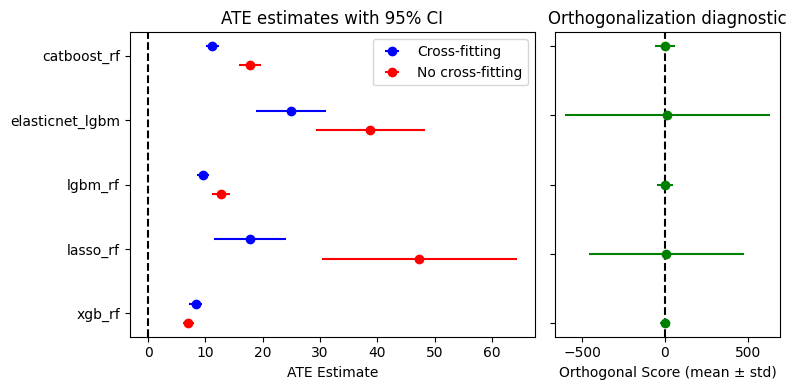

KeyboardInterrupt: 

In [75]:
analysis = DoubleMLAnalysis(
        data=data,
        X_cols=["carbon_emission_lag1", "temperature", "radiation", "precipitation",
                "surface temp", "windspeed", "GDP", "population", "age",
                "education", "gender", "Hhsize", "wealth", "rural"],
        y_col="carbon emission",
        d_cols="HDD_days"
    )

# 1 & 2: 主分析 + 多 learner + cross-fitting 对比 + orthogonal score
results = analysis.run_analysis(n_splits=5)
print("Full sample results:")
print(results)
analysis.plot_forest()

# 3: 不同估计方法对比
other_est = analysis.compare_estimators()
print("Other estimators (full sample):")
print(other_est)

# 4: 模型假设检查（共支持性）
support_check = analysis.check_common_support(lower=0.05, upper=0.95, do_trim=True, plot=True)
print("Common support check:")
print(support_check)

# 5: Placebo test
placebo_res = analysis.placebo_test(n_perm=200)
print(placebo_res)

**Heterogeneity analysis**


Running analysis for Wealth Group: Low


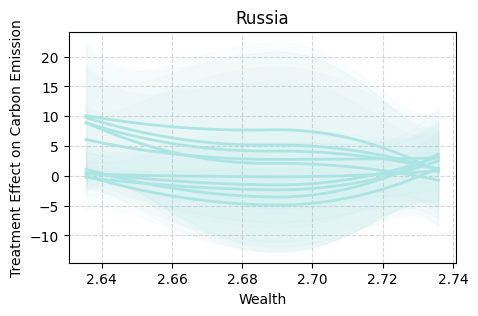


=== Low Wealth - Main Analysis (LASSO+RF) ===
                     coef_mean  coef_std  std_err_mean  t_mean  p_value_mean
model_type term                                                             
Main       HDD_days     -0.222    1.0513        1.1968 -0.1883        0.6584

=== Low Wealth - Robustness Check (XGBoost+RF) ===
                     coef_mean  coef_std  std_err_mean  t_mean  p_value_mean
model_type term                                                             
Robust     HDD_days     4.0457    1.0378        2.0732  1.9633        0.0768

Running analysis for Wealth Group: Medium


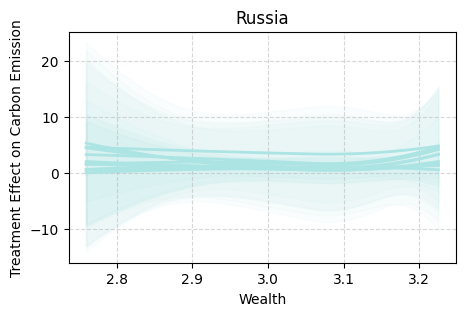


=== Medium Wealth - Main Analysis (LASSO+RF) ===
                     coef_mean  coef_std  std_err_mean  t_mean  p_value_mean
model_type term                                                             
Main       HDD_days     1.0931    0.5236        1.3958  0.8049        0.4573

=== Medium Wealth - Robustness Check (XGBoost+RF) ===
                     coef_mean  coef_std  std_err_mean  t_mean  p_value_mean
model_type term                                                             
Robust     HDD_days     3.4037    0.8504        2.5271  1.3366        0.1917

Running analysis for Wealth Group: High


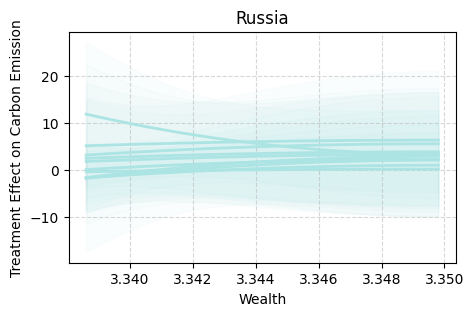


=== High Wealth - Main Analysis (LASSO+RF) ===
                     coef_mean  coef_std  std_err_mean  t_mean  p_value_mean
model_type term                                                             
Main       HDD_days     1.1988    0.8423        2.0757  0.5547        0.5995

=== High Wealth - Robustness Check (XGBoost+RF) ===
                     coef_mean  coef_std  std_err_mean  t_mean  p_value_mean
model_type term                                                             
Robust     HDD_days     4.5498    1.2674        2.4434  1.8676        0.0915

Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [ ]:
if __name__ == "__main__":
    # 首先将财富分为三个组别
    data['wealth_group'] = pd.qcut(data['wealth'], q=3, labels=["Low", "Medium", "High"])

    all_summaries = {}

    for group in ["Low", "Medium", "High"]:
        print(f"\n{'='*40}\nRunning analysis for Wealth Group: {group}\n{'='*40}")

        # 筛选当前组别的数据
        group_data = data[data['wealth_group'] == group].copy()

        # 初始化分析器
        analysis = DoubleMLAnalysis(
            data=group_data,
            X_cols=["carbon_emission_lag1", "temperature", "radiation", "precipitation",
                    "surface temp", "windspeed", "GDP", "population", "age",
                    "education", "gender", "Hhsize", "rural"],  # 移除了wealth_group列避免多重共线性)
            y_col="carbon emission",
            d_cols="HDD_days"
        )

        # 运行分析
        analysis.run_analysis(num_runs=5)

        # 存储结果
        summaries = analysis.get_summary_stats()
        all_summaries[group] = summaries

        # 打印当前组别结果
        print(f"\n=== {group} Wealth - Main Analysis (XGBoost+RF)  ===")
        print(summaries['main'].round(4))

        print(f"\n=== {group} Wealth - Robustness Check (LASSO + RF)  ===")
        print(summaries['robust'].round(4))

    # 打印所有组别的显著性标记
    print("\nSignif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")

**Fixed effects model**

In [ ]:
! pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from linearmodels.panel import PooledOLS
from linearmodels.panel import compare

In [ ]:
data['time'] = pd.to_datetime(data['time'].str.replace('_', '-') + '-01')
data = data.set_index(['GDLcode', 'time'])

y = data["carbon emission"]
X = data[["HDD_days", "temperature", "radiation", "windspeed",
          "population", "age", "gender", "Hhsize", "wealth", "rural"]]  #"carbon_emission_lag1", "precipitation", "surface temp", "GDP", "education"
X = sm.add_constant(X)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 计算 VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# Calculate VIF for all columns in X, including the constant
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

print("\n=== Variance Inflation Factor (VIF) ===")
print(vif_data)


=== Variance Inflation Factor (VIF) ===
        feature          VIF
0         const  8543.752652
1      HDD_days     2.340079
2   temperature     3.678272
3     radiation     2.857614
4     windspeed     1.260199
5    population     1.324448
6           age     1.949274
7        gender     1.136362
8        Hhsize     2.181466
9        wealth     1.244857
10        rural     1.492768


In [ ]:
# One-Way 固定效应模型（实体固定效应）
model_oneway = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
results_oneway = model_oneway.fit()

# Two-Way 固定效应模型（实体 + 时间）
model_twoway = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
results_twoway = model_twoway.fit()

# OLS
model_ols = PooledOLS(y, X)
results_ols = model_ols.fit()

comparison = compare({'OneWayFE': results_oneway, 'TwoWayFE': results_twoway, 'OLS':results_ols})
print(comparison)

                                  Model Comparison                                 
                                   OneWayFE            TwoWayFE                 OLS
-----------------------------------------------------------------------------------
Dep. Variable               carbon emission     carbon emission     carbon emission
Estimator                          PanelOLS            PanelOLS           PooledOLS
No. Observations                      12661               12661               12661
Cov. Est.                        Unadjusted          Unadjusted          Unadjusted
R-squared                            0.5146              0.0229              0.3565
R-Squared (Within)                   0.5146             -0.3849              0.4625
R-Squared (Between)                 -4.4452             -3.2301              0.2463
R-Squared (Overall)                 -2.1681             -2.0262              0.3565
F-statistic                          2630.6              57.896             